[View in Colaboratory](https://colab.research.google.com/github/leviner/CabledArray/blob/master/Coastal_Endurance_Glider_Data_Validation_Report.ipynb)

#**Coastal Endurance (CE05MOAS) Glider GL311 and GL383 Data Quality Report**

**Evaluation Date:** 6/22/2018

**Evaluator: ** Robert Levine and Adrienne Copeland

##**Review Summary**

![alt text](http://oceanobservatories.org/wp-content/uploads/2018/03/CEV-OOI-Endurance-Array.jpg)


This report summarizes a data quality review of the Coastal Endurance Glider flourometer data from October 2016 - May 2017.  This report focuses on two gilders, GL311 and GL383, because they both made similar passes over the Newport (44.7 degrees) and Coos Bay Lines (43.5 degrees) during the dates of interest.  These dates were selected because they might have been during the winter storm season and were in-between research cruises so probably have not been reviewed in the past. We focused on the fluorometer data because there is potential for this data to degrade over time.  A comparison between two gliders might help elucidate problems that might not be apparent.  Due to issues with the data timing out during download, this notebook also provides examples on three different ways for getting your data into a colab environment. Review Section 10 for the outcomes of this report.





|CE05MOAS Gliders Reviewed ||
|---|---|---|
| **Glider** | **Date Range** | **Number of Deployments **|
|GL311|10/11/2016 - 1/6/2017|1|
|GL383|1/31/2017 - 5/10/2017|1|

## **1. Selected instruments included in this report**
In this report, we will evaluated the Fluorometer data from the Glider Mobile Platform within the Coastal Endurance (CE05MOAS).  We are focusing on the data from two specific gliders (GL311 and GL383) over the fall 2016 to spring 2017 time period.  We are focusing on one deployement for each glider: GL311 - Deployment 3 and GL383 - Deployment 4.

|Costal Endurance Mobile Platforms ||
|---|---|---|
| **Instrument** | **Reference Designer** | **Method** | **Stream** |
|Fluorometer| [CE05MOAS-GL311-02-FLORTM000](http://ooi.visualocean.net/instruments/view/CE05MOAS-GL311-02-FLORTM000) | Telemetered | flort_m_sample | 
|Fluorometer|[CE05MOAS-GL383-02-FLORTM000](http://ooi.visualocean.net/instruments/view/CE05MOAS-GL383-02-FLORTM000)| Telemetered | flort_m_sample |



**Installing required libraries and import packages.**

In [81]:
# Bring in the libraries necessary for data handling and plots
import requests
import datetime
import matplotlib.pyplot as plt
!pip install cmocean
import cmocean
import numpy as np
import pandas as pd

## **2. Data Retrieval**
**Time periods of interest**

We will focus on the following time periods for evaluation:

*   October 11, 2016 to January 6, 2017 - All of GL311 Deployment 3
*    January 31, 2017 to April 10, 2017 - All of GL383 Deployment 4

In [0]:
# API Information
username = 'OOIAPI-I0UCP16V67ENKZ'
token =  '4CUPODF4AL256S'
dataAPI = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
vocabAPI = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
assetAPI = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

In [0]:
site = 'CE05MOAS' #Coastal Endurance Mobile Assets
nodes = ['GL311', 'GL383'] #These are our two gliders
sensor = '02-FLORTM000' # Using the WET Labs ECO Puck 3-Wavelength Fluorometer
method = 'telemetered' # Telemetered data
stream = 'flort_m_sample' # Fluorometer data stream
# Since each of the gliders only had one deployment during Fall 2016 - Spring 2017, we can specify one date range for both requests
beginDT = '2016-10-01T01:01:01.900Z' # 
endDT = '2017-06-01T01:01:01.900Z'

## **3. Related Metadata** 
In this section, we will review some of the metadata available in the system to make sure it is present and correct.


### **3a. Vocabulary Metadata**

In [0]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None

In [0]:
vocabData = []
dfVocab = pd.DataFrame() # Setup empty array
#Create our data requests
for node in nodes:
  # Setup the API request url
  data_request_url ='/'.join((vocabAPI,site,node,sensor))
  print(data_request_url)

  # Grab the information from the server
  r = requests.get(data_request_url, auth=(username, token))
  vocabData = (r.json())
  for d in vocabData:
    dfVocab = dfVocab.append({
      'Site': d['tocL1'],
      'Node': d['tocL3'],
      'Instrument': d['instrument'],
      'Manufacturer': d['manufacturer'],
      'Model': d['model'],
      'Reference Designator': d['refdes'],
      'Depth Range (m)': str(d['mindepth']) + ' - ' +str(d['maxdepth']),
      }, ignore_index=True)
    

dfVocab = pd.DataFrame(dfVocab, columns = ['Instrument', 'Manufacturer','Model','Site', 'Reference Designator', 'Node', 'Depth Range (m)'])
dfVocab

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CE05MOAS/GL311/02-FLORTM000
https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CE05MOAS/GL383/02-FLORTM000


Instrument Manufacturer                Model  \
0  3-Wavelength Fluorometer     WET Labs  ECO Puck FLBBCD-SLK   
1  3-Wavelength Fluorometer     WET Labs  ECO Puck FLBBCD-SLK   

                Site         Reference Designator                Node  \
0  Coastal Endurance  CE05MOAS-GL311-02-FLORTM000  Coastal Glider 311   
1  Coastal Endurance  CE05MOAS-GL383-02-FLORTM000  Coastal Glider 383   

  Depth Range (m)  
0     0.0 - 200.0  
1     0.0 - 200.0

This all looks good.

### 3b. Deployment Information

In [0]:
# Setup the API request url
data_request_url = assetAPI + '/events/deployment/query'
dfAsset = pd.DataFrame() # Setup empty array
#deployData = []
for node in nodes:
  params = {
   'beginDT':'2016-10-01T00:00:00.000Z',
   'endDT':'2017-06-01T00:00:00.000Z',
   'refdes':site+'-'+node+'-'+sensor,   
    }

  # Grab the information from the server
  r = requests.get(data_request_url, params=params, auth=(username, token))
  assetData = r.json()

  for d in assetData:
    dfAsset = dfAsset.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
      }, ignore_index=True)
dfAsset = dfAsset[pd.to_datetime(dfAsset['start']) > pd.to_datetime('2016-10-01T00:00:00.000Z')]
dfAsset

asset_id  deployment  latitude  longitude              sensor  \
1     998.0         3.0   44.6350  -124.3110  CGINS-FLORTM-04258   
3    2626.0         4.0   44.6578  -124.1866  CGINS-FLORTM-04470   

                start                stop  
1 2016-10-11 21:01:00 2017-01-06 04:55:00  
3 2017-01-31 19:42:00 2017-05-10 22:24:00

### 3c. Calibration Information

When the system delivers data, it often uses a number of calibration coefficients to generated derived data products.



In [0]:
dfCal = pd.DataFrame()
for node in nodes:
  # Setup the API request url# Setup 
  data_request_url = assetAPI + '/asset/cal'
  params = {
   'beginDT':'2017-05-01T00:00:00.000Z',
   'endDT':'2017-06-01T00:00:00.000Z',
    'refdes':site+'-'+node+'-'+'02-FLORTM000',
      }
  # Grab the information from the server
  r = requests.get(data_request_url, params=params, auth=(username, token))
  data = r.json()
  # Reformat the data into a pretty table
  for d in data:
    for dd in d['sensor']['calibration']:
      for ddd in dd['calData']:
        dfCal = dfCal.append({
          'value': ddd['value'],
          'start': convert_time(ddd['eventStartTime']),
          'stop': convert_time(ddd['eventStopTime']),
          'name': ddd['eventName'],
          'assetUid': ddd['assetUid'],
          }, ignore_index=True)

  dfCal = dfCal.sort_values(by=['start','name'])
dfCal

assetUid                       name      start  stop    value
4  CGINS-FLORTM-04470      CC_angular_resolution 2016-08-24  None    1.076
7  CGINS-FLORTM-04470    CC_depolarization_ratio 2016-08-24  None    0.039
5  CGINS-FLORTM-04470  CC_measurement_wavelength 2016-08-24  None  700.000
6  CGINS-FLORTM-04470        CC_scattering_angle 2016-08-24  None  124.000
0  CGINS-FLORTM-04258      CC_angular_resolution 2016-10-11  None    1.076
1  CGINS-FLORTM-04258    CC_depolarization_ratio 2016-10-11  None    0.039
2  CGINS-FLORTM-04258  CC_measurement_wavelength 2016-10-11  None  700.000
3  CGINS-FLORTM-04258        CC_scattering_angle 2016-10-11  None  124.000

From the deployment table above, we can see that GL311 Deployment 3 began on October 11, 2016.  For GL 383, the Deployment 4 began on January 31, 2017.  The system uses the calibration values that are closest in time but before the deployment start date. Note also, that calibrations do not have an end date. It is assumed they are valid until the next calibration for the specific asset.

So in this case, for Deployment 3, the calibration values from October 11, 2016 were used, which was the date of deployment. For Deployment 4, the calibration values of August 24, 2016 were used. Since this is only a few months before the deployment, when the instrument would have been on land, this makes sense.

### 3d. Annotations

Then we pulled any relevant annotations for the two Fluorometer instruments.

In [0]:
dfAnno = pd.DataFrame() # Setup empty array
numAnno = 0
annoAPI  = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
for node in nodes:
  params = {
    'beginDT':int(datetime.date(2016,10,1).strftime('%s'))*1000,
    'endDT':int(datetime.date(2017,6,1).strftime('%s'))*1000,
    'refdes':site+'-'+node+'-'+sensor,
  }

  r = requests.get(annoAPI, params=params, auth=(username, token))
  data = r.json()
  numAnno+=len(data)
  for d in data:
    dfAnno = dfAnno.append({
      'annotation': d['annotation'],
      'start': convert_time(d['beginDT']),
      'stop': convert_time(d['endDT']),
      'site': d['subsite'],
      'node': d['node'],
      'sensor': d['sensor'],
      'id': d['id']
    }, ignore_index=True)
  pd.set_option('display.max_colwidth', -1) # Show the full annotation text
print('Number of Annotations: '+ str(numAnno))
if numAnno:
  dfAnno

Number of Annotations: 0


It looks like there are no annotations for either of the two deployments.

## **4. Requesting the Full Dataset**

Now we look at a large range of data. First we need to add some additional libraries to our Python environment.

In [82]:
# We will need a few more libraries for handing the full dataset once it is requested
!pip install netCDF4
import netCDF4 as nc
!pip install xarray
!pip install dask
import xarray as xr
import os, re
import matplotlib.pyplot as plt
!pip install cmocean
import cmocean
import requests

Let's put together the rest of the information we will need for the request.  The site and node information is already defined from our previous API requests above.

In [0]:
# Universal url for the m2m (OOI API) for requesting sensor data
sensorBaseUrl = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
dataRequestUrl=[]
# We're going to make two separate data requests, so we'll append the urls to a list
for node in nodes:
# Create the request URL
  dataRequestUrl.append('/'.join((sensorBaseUrl,site,node,sensor,method,stream)))

# There's a single window which contains the deployments from both nodes, so we 
# can set the request parameters once.
params = {
  'beginDT':'2016-10-01T00:00:00.000Z', #set a start time
  'endDT':'2017-06-01T00:00:00.000Z', # set an end time
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

Now we can make both requests at once (remember to comment this, so we only do it once):

In [0]:
# data = []
# for url in dataRequestUrl:
#   r = requests.get(url, params=params, auth=(username, token))
#   data.append(r.json())
# data

Let's hardcode the urls to the THREDDS server so that we do not have to make the request or find the email to obtain that information.

In [0]:
urlData = ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/leviner@uw.edu/20180620T184611-CE05MOAS-GL311-02-FLORTM000-telemetered-flort_m_sample/catalog.html',
  'https://opendap.oceanobservatories.org/thredds/catalog/ooi/leviner@uw.edu/20180620T184618-CE05MOAS-GL383-02-FLORTM000-telemetered-flort_m_sample/catalog.html' ]

And now we can get a list of the netCDF files that are being held in THREDDS:

In [85]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'

datasetsAll = []
for url in urlData:
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
  for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
  datasets = [tds_url+'/'+ i for i in x]
  datasetsAll.append(datasets)
datasetsAll

[['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/leviner@uw.edu/20180620T184611-CE05MOAS-GL311-02-FLORTM000-telemetered-flort_m_sample/deployment0003_CE05MOAS-GL311-05-CTDGVM000-telemetered-ctdgv_m_glider_instrument_20161011T215849.332760-20161225T064830.720830.nc',
  'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/leviner@uw.edu/20180620T184611-CE05MOAS-GL311-02-FLORTM000-telemetered-flort_m_sample/deployment0003_CE05MOAS-GL311-02-FLORTM000-telemetered-flort_m_sample_20161011T215849.332760-20161225T042409.840480.nc',
  'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/leviner@uw.edu/20180620T184611-CE05MOAS-GL311-02-FLORTM000-telemetered-flort_m_sample/deployment0003_CE05MOAS-GL311-00-ENG000000-telemetered-glider_gps_position_20161011T215853.659580-20161225T070153.194790.nc'],
 ['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/leviner@uw.edu/20180620T184618-CE05MOAS-GL383-02-FLORTM000-telemetered-flort_m_sample/deployment0004_CE05MOAS-GL383-05-CTD

The file list contains the FLORT sensor file, as well as a CTD and GPS files which are used to calculate the scientific products for the fluorometer. We can separate these out into different lists for when we only want to read in or work with one type of file (i.e., if we need to concatenate a larger dataset).

In [0]:
dataFlort = []
dataCTD = []
dataGPS = []
for data in datasetsAll:
  dataFlort.append(data[1])
  dataCTD.append(data[0])
  dataGPS.append(data[2])

##  **5. Investigating the Datasets**

### 5a. GL311 Plotting

Let's start by bringing in one of our datasets by directly accessing the GL311 fluoromter netCDF.

In [87]:
ds311 = xr.open_dataset(dataFlort[0])
ds311 = ds311.swap_dims({'obs': 'time'}) 
ds311;

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


On occasion, there appears to be some difficulty with colab timing out during THREDDS requests, so we will use this as an opportunity to test how Google Colab handles local file uploads. We can directly upload the data from a local drive before reading it into xarray using the example below.

This will remain commented out when not used:

In [0]:
# from google.colab import files # import Google Colab's own file handling library
# files.upload() # create an upload instance, where you are prompted to select files directly from your computer

# ds311 = xr.open_dataset('deployment0003_CE05MOAS-GL311-02-FLORTM000-telemetered-flort_m_sample_20161011T215849.332760-20161225T042409.840480.nc')
# ds311 = ds311.swap_dims({'obs': 'time'}) 
# ds311;

For GL311, let's start by just mapping out the track of the glider from the GPS stored in the FLORT sensor.  We can use time as the color scale so that the track goes from dark to light colors as you increase in time. We also included plots of temperature, salinity, and chlorophyll for the entire time series.

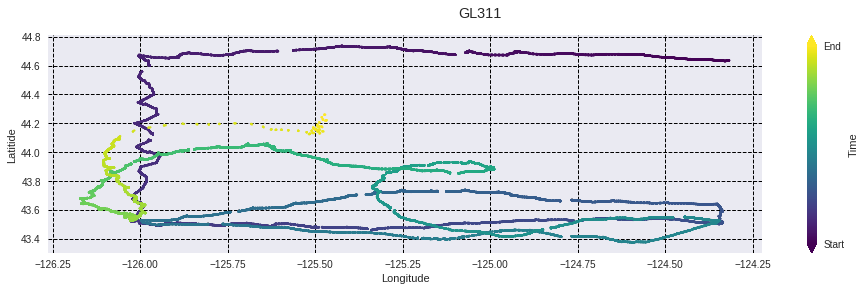

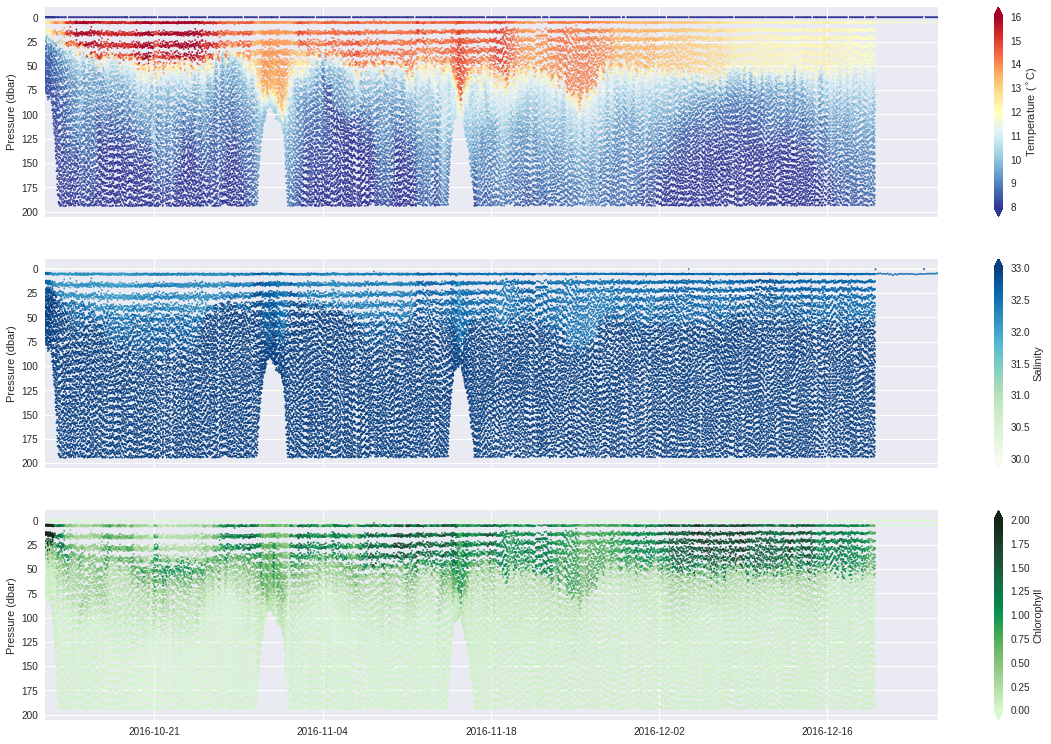

In [8]:
dtime = ds311['time'].values
pressure = ds311['int_ctd_pressure'].values
temperature = ds311['sci_water_temp'].values
salinity = ds311['practical_salinity'].values
chlor = ds311['sci_flbbcd_chlor_units'].values
lat = ds311['lat'].values
lon = ds311['lon'].values

fig1, (ax4) = plt.subplots(1,1, figsize=(16,4))
sc4 = ax4.scatter(lon, lat, c=dtime, cmap='viridis', s=4)
ax4.set_ylabel('Latitide')
ax4.set_xlabel('Longitude')
ax4.grid(color='k', linestyle='--', linewidth=1)
fig1.suptitle('GL311')
cbar = fig1.colorbar(sc4, ax=ax4, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Time')
cbar.set_ticks([dtime.min().astype('float'),dtime.max().astype('float')])
cbar.ax.set_yticklabels(['Start','End'])

fig, (ax1,ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,12))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc1.set_clim(8, 16)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)
sc2.set_clim(30, 33)
sc3 = ax3.scatter(dtime, pressure, c=chlor, cmap=cmocean.cm.algae, s=2)
sc3.set_clim(0, 2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar.set_clim(8, 16)
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')
cbar.set_clim(30, 33)
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll')
cbar.set_clim(0, 2)


ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')
ax3.set_ylabel('Pressure (dbar)')
fig.subplots_adjust(top=0.95);

And we can plot the histrograms to look at the distribution of values collected by the fluorometer and CTD.  

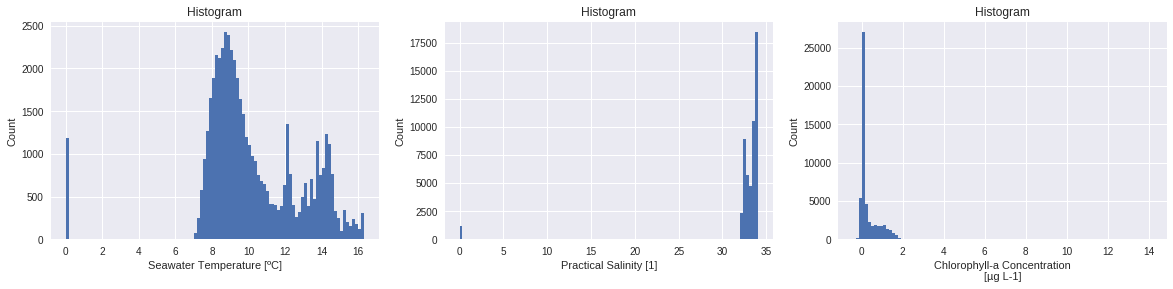

In [0]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,4))
ds311['sci_water_temp'].plot.hist(bins=100, ax=ax1)
ds311['practical_salinity'].plot.hist(bins=100, ax=ax2);
ds311['sci_flbbcd_chlor_units'].plot.hist(bins=100, ax=ax3);

Right off the bat we can see there's something funky going on with the CTD dataset, which might explain the values we see at the surface in the figures above.

It looks like the glider was launched from the Newport line.  Let's determine and plot the data points that are within the time frame of the first run along the Coos Bay line.

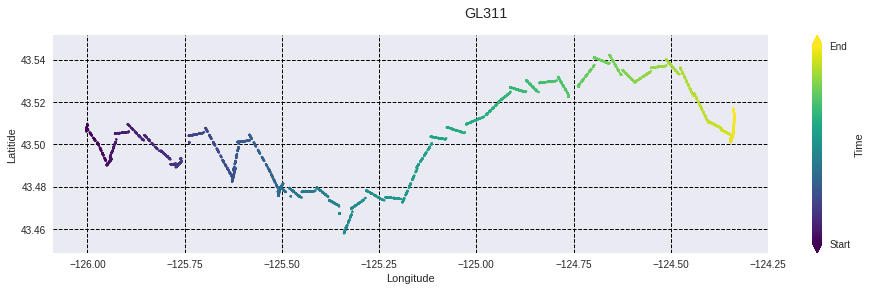

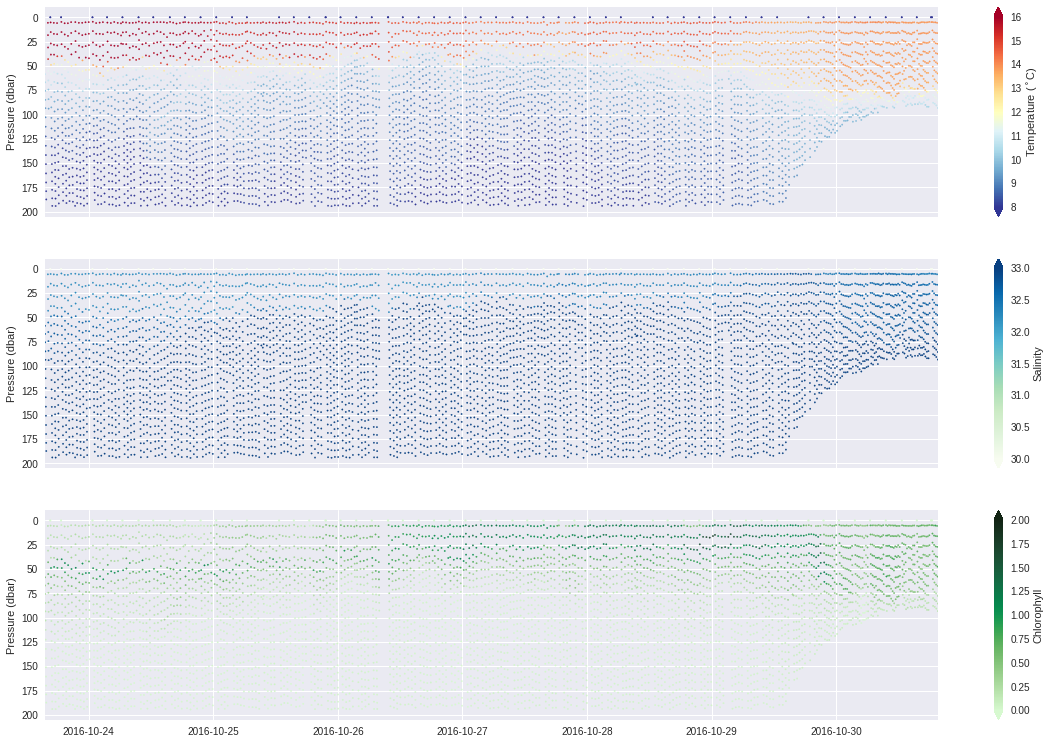

In [0]:
dtime = ds311['time'].values[9000:14500]
pressure = ds311['int_ctd_pressure'].values[9000:14500]
temperature = ds311['sci_water_temp'].values[9000:14500]
salinity = ds311['practical_salinity'].values[9000:14500]
chlor = ds311['sci_flbbcd_chlor_units'].values[9000:14500]
lat = ds311['lat'].values[9000:14500]
lon = ds311['lon'].values[9000:14500]

fig1, (ax4) = plt.subplots(1,1, figsize=(16,4))
sc4 = ax4.scatter(lon, lat, c=dtime, cmap='viridis', s=4)
ax4.set_ylabel('Latitide')
ax4.set_xlabel('Longitude')
ax4.grid(color='k', linestyle='--', linewidth=1)
fig1.suptitle('GL311')
cbar = fig1.colorbar(sc4, ax=ax4, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Time')
cbar.set_ticks([dtime.min().astype('float'),dtime.max().astype('float')])
cbar.ax.set_yticklabels(['Start','End'])


fig, (ax1,ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,12))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc1.set_clim(8, 16)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)
sc2.set_clim(30, 33)
sc3 = ax3.scatter(dtime, pressure, c=chlor, cmap=cmocean.cm.algae, s=2)
sc3.set_clim(0, 2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar.set_clim(8, 16)
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')
cbar.set_clim(30, 33)
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll')
cbar.set_clim(0, 2)


ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')
ax3.set_ylabel('Pressure (dbar)')
fig.subplots_adjust(top=0.95);

Here we can see that artifact at the surface a bit more obvious.  More on that later (see Sections 8 and 9)

### **5b. GL383 Plotting** 
For the smaller glider dataset (GL383), we can use `xarray` to open the dataset directly.

In [58]:
ds383 = xr.open_dataset(dataFlort[1])
#ds383 = xr.open_dataset('deployment0004_CE05MOAS-GL383-02-FLORTM000-telemetered-flort_m_sample_20170131T203658.051610-20170510T174958.052980.nc')
ds383 = ds383.swap_dims({'obs': 'time'}) # Swap the primary dimension
#ds383 = ds383.chunk({'time': 100}) # Used for optimization
#ds383 = ds383.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [0]:
#Now we pull out the values we are interested in for this data validation
ds383time = ds383['time'].values
ds383pressure = ds383['int_ctd_pressure'].values
ds383chlorophyll = ds383['sci_flbbcd_chlor_units'].values
ds383temp = ds383['sci_water_temp'].values
ds383salinity = ds383['practical_salinity'].values
ds383lat = ds383['lat'].values
ds383lon = ds383['lon'].values

For GL383, let's start by just mapping out the track of the glider from the GPS stored in the FLORT sensor.  We can use time as the color scale so that the track goes from dark to light colors as you increase in time. We also included plots of temperature, salinity, and chlorophyll for the entire time series.

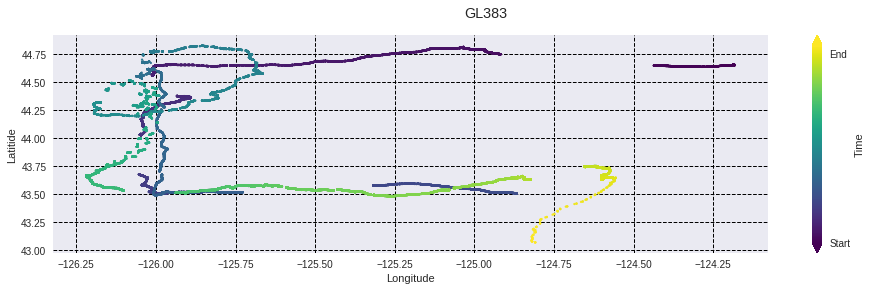

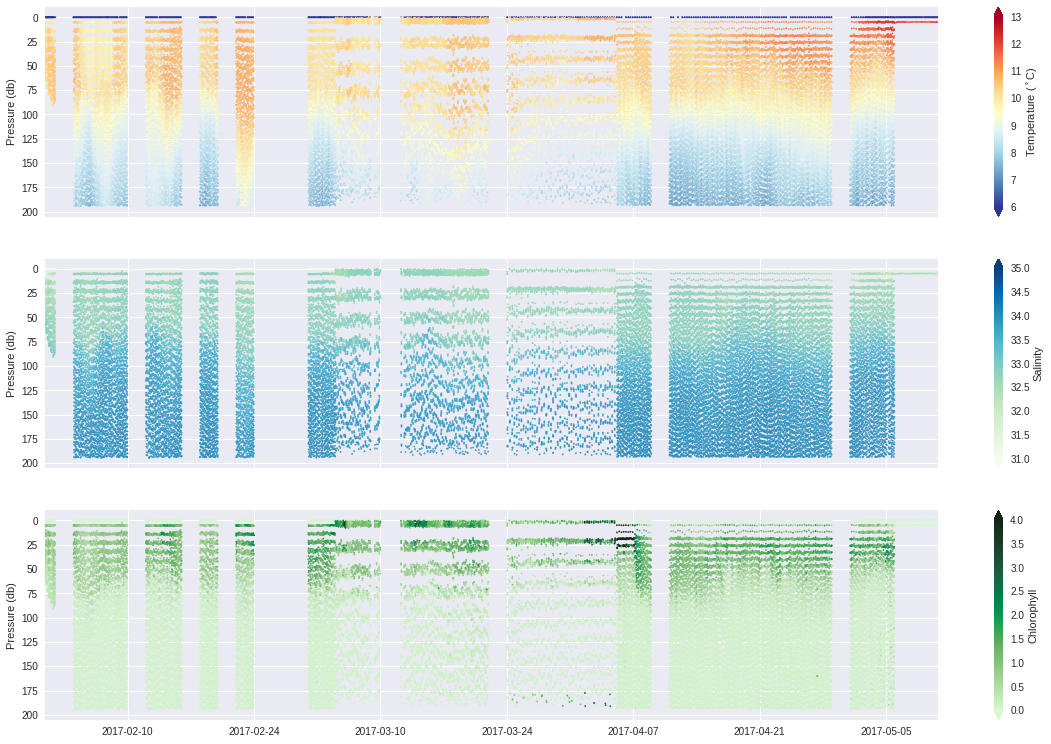

In [0]:
fig1, (ax4) = plt.subplots(1,1, figsize=(16,4))
sc4 = ax4.scatter(ds383lon, ds383lat, c=ds383time, cmap='viridis', s=4)
ax4.set_ylabel('Latitide')
ax4.set_xlabel('Longitude')
ax4.grid(color='k', linestyle='--', linewidth=1)
fig1.suptitle('GL383')
cbar = fig1.colorbar(sc4, ax=ax4, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Time')
cbar.set_ticks([ds383time[100].astype('float'),ds383time[-100].astype('float')])
cbar.ax.set_yticklabels(['Start','End'])


fig, (ax1,ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,12))
sc1 = ax1.scatter(ds383time, ds383pressure, c=ds383temp, cmap='RdYlBu_r', s=2)
sc1.set_clim(6, 13)
sc2 = ax2.scatter(ds383time, ds383pressure, c=ds383salinity, cmap='GnBu', s=2)
sc2.set_clim(31, 35)
sc3 = ax3.scatter(ds383time, ds383pressure, c=ds383chlorophyll, cmap=cmocean.cm.algae, s=2)
sc3.set_clim(0, 4)

# Because the X and Y axes are shared, we only have to set limits once
ax2.invert_yaxis() # Invert y axis
ax2.set_xlim(ds383time[0],ds383time[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')
ax3.set_ylabel('Pressure (db)')

fig.subplots_adjust(top=0.95);

And we can plot the histrograms to look at the distribution of values collected by the fluorometer and CTD.  

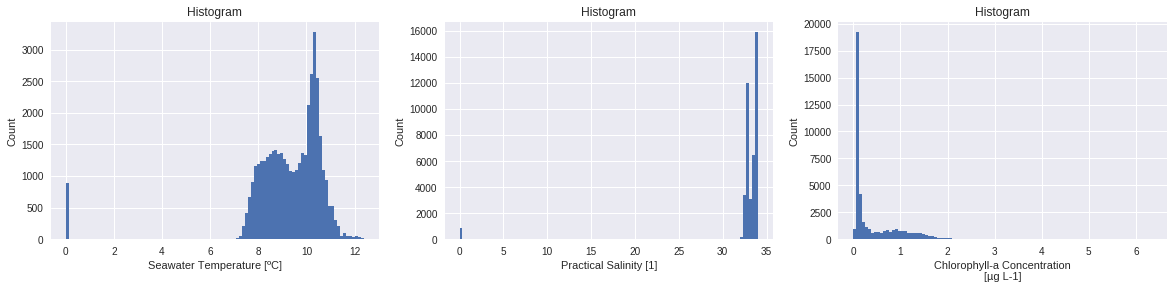

In [0]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,4))
ds383['sci_water_temp'].plot.hist(bins=100, ax=ax1)
ds383['practical_salinity'].plot.hist(bins=100, ax=ax2);
ds383['sci_flbbcd_chlor_units'].plot.hist(bins=100, ax=ax3);

There seems to be some interesting things happening in this data set.  
There seems to be a high number of zero values.  We will invesitgate this in Section 8. There seems to be a decrease in the sampling rate about a third of the way through the deployment.  Additionally there is an increase in the chlorophyll valus from 175 - 200 meters and near the suface about halfway through the dataset.  Let's zoom in on these features to see if they are real.

## ** 6. GL383: Investigating the Sample Rate **

This section zooms into the GL383 dataset to show very clearly the change in sample rate.  This is not an issue per se but it is important to keep in mind that the pilots can change the sample rate throughout a deployment leading to patchy collection of data.

In [0]:
#Getting the obs number for the time of interest including the change in sample rate
print('Starting index: ' + str(ds383.sel(time=slice('2017-02-15', '2017-03-15'))['obs'].values[0]) + ', Ending index: '+ str(ds383.sel(time=slice('2017-02-15', '2017-03-15'))['obs'].values[-1]))

Starting index: 7970, Ending index: 17607


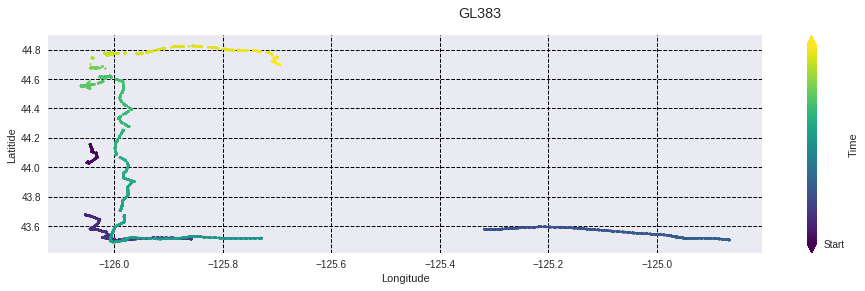

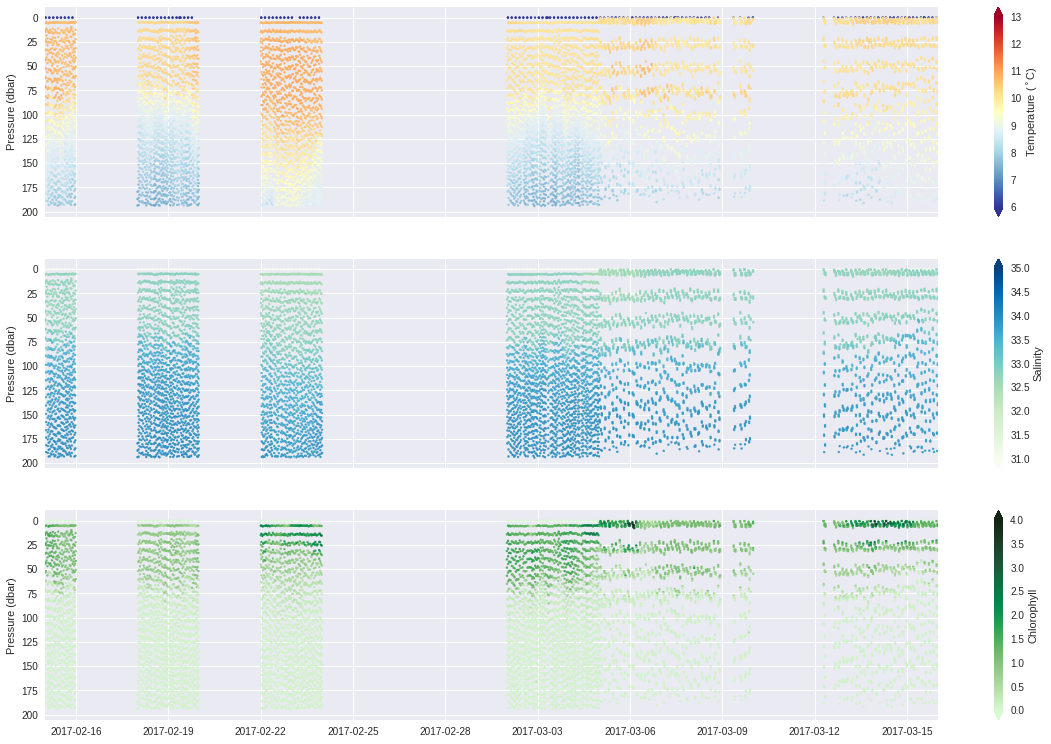

In [0]:
#Plotting the subsetted GL383 Data investigating the change in sample rate
fig1, (ax4) = plt.subplots(1,1, figsize=(16,4))
sc4 = ax4.scatter(ds383lon[7970:17607], ds383lat[7970:17607], c=ds383time[7970:17607], cmap='viridis', s=4)
ax4.set_ylabel('Latitide')
ax4.set_xlabel('Longitude')
ax4.grid(color='k', linestyle='--', linewidth=1)
fig1.suptitle('GL383')
cbar = fig1.colorbar(sc4, ax=ax4, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Time')
cbar.set_ticks([ds383time[17608].astype('float'),ds383time[7970].astype('float')])
cbar.ax.set_yticklabels(['Start','End'])

fig, (ax1,ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,12))
sc1 = ax1.scatter(ds383time[7970:17607], ds383pressure[7970:17607], c=ds383temp[7970:17607], cmap='RdYlBu_r', s=4)
sc1.set_clim(6, 13)
sc2 = ax2.scatter(ds383time[7970:17607], ds383pressure[7970:17607], c=ds383salinity[7970:17607], cmap='GnBu', s=4)
sc2.set_clim(31, 35)
sc3 = ax3.scatter(ds383time[7970:17607], ds383pressure[7970:17607], c=ds383chlorophyll[7970:17607], cmap=cmocean.cm.algae, s=4)
sc3.set_clim(0, 4)

# Because the X and Y axes are shared, we only have to set limits once
ax2.invert_yaxis() # Invert y axis
ax2.set_xlim(ds383time[7970],ds383time[17607]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')
ax3.set_ylabel('Pressure (dbar)')

fig.subplots_adjust(top=0.95);

Zooming into the data you can clearly see that the sample date does change. The pilots can change the sample rate throughout the deployment to help conserve battery power.  It will be important to keep this in mind because the data can be spatially patchy.  See Section 10 and the code at the end of this report that further expands on this.

## ** 7. GL383: Investigating the Cholophyll Increase**
For GL383, there is an increase in the chlorophyll valus from a depth of about 175 - 200 meters about halfway through the dataset.  There is also an increase at the surface immediately following this peak.  Let's zoom in on these features and compare them to other datasets to see if they are real.



In [0]:
#Now we subset the data with the interesting chlorophyll values at depth
print('Starting index: ' + str(ds383.sel(time=slice('2017-03-24', '2017-04-05'))['obs'].values[0]) + ', Ending index: '+ str(ds383.sel(time=slice('2017-03-24', '2017-04-05'))['obs'].values[-1]))

Starting index: 20034, Ending index: 23131


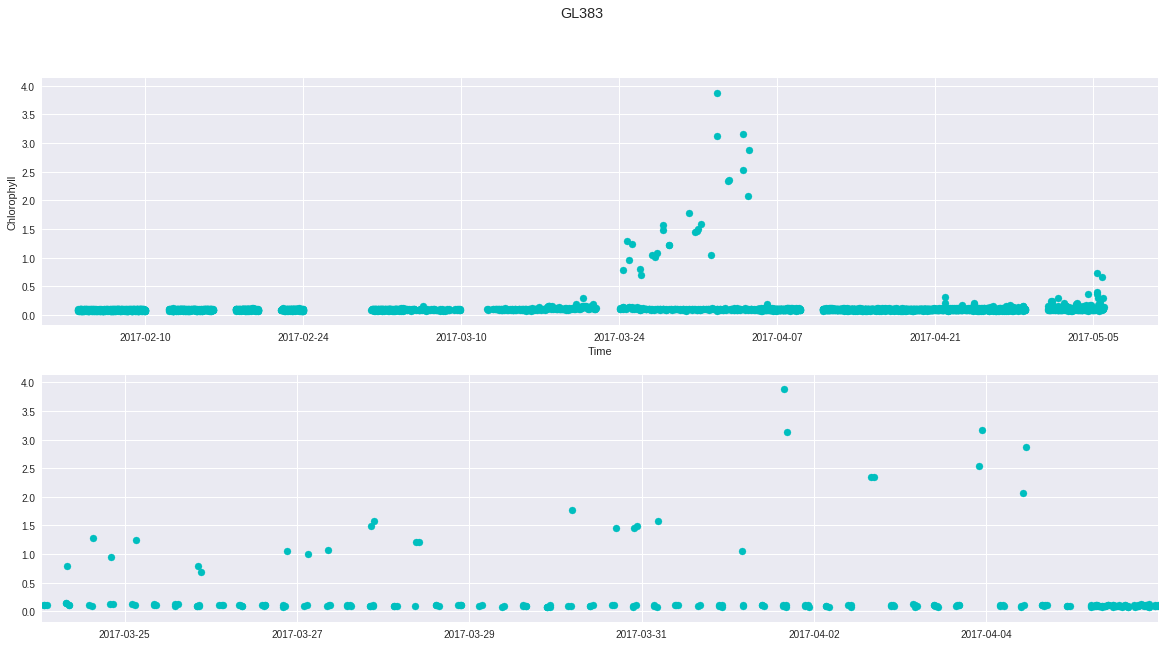

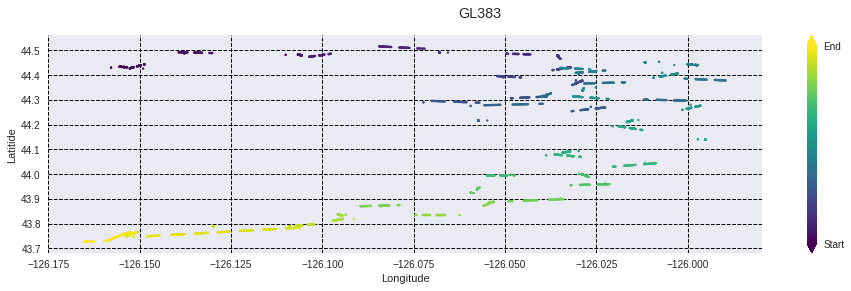

In [0]:
#Now lets look at this spike in cholophyll over time
fig,(ax1,ax2) = plt.subplots(2,1, sharey=True, figsize=(20,10))
fig.suptitle('GL383')
ax1.scatter(ds383['time'].values[(ds383['int_ctd_pressure'] >175) & (ds383['int_ctd_pressure'] <200)],ds383['sci_flbbcd_chlor_units'].values[(ds383['int_ctd_pressure'] >175) & (ds383['int_ctd_pressure'] <200)],color='c')
ax1.set_title('')
ax1.set_xlabel('Time')
ax1.set_ylabel('Chlorophyll')
ax1.set_xlim(ds383['time'].values[0],ds383['time'].values[-1])

ds383time = ds383['time'].values[20034:23131]
ds383chlo = ds383['sci_flbbcd_chlor_units'].values[20034:23131]
ax2.scatter(ds383time[(ds383['int_ctd_pressure'][20034:23131] >175) & (ds383['int_ctd_pressure'][20034:23131] <200)], ds383chlo[(ds383['int_ctd_pressure'][20034:23131] >175) & (ds383['int_ctd_pressure'][20034:23131] <200)],color='c')
ax2.set_xlim(ds383['time'].values[20034],ds383['time'].values[23131])

fig2, (ax1) = plt.subplots(1,1, figsize=(16,4))
sc4 = ax1.scatter(ds383['lon'].values[20034:23131], ds383['lat'].values[20034:23131],c=ds383['time'].values[20034:23131], cmap='viridis', s=4)
ax1.set_ylabel('Latitide')
ax1.set_xlabel('Longitude')
ax1.grid(color='k', linestyle='--', linewidth=1)
fig2.suptitle('GL383')
cbar = fig2.colorbar(sc4, ax=ax1, orientation='vertical', extend='both')
#cbar.ax.set_ylabel('Time')
cbar.set_ticks([ds383time[0].astype('float'),ds383time[-1].astype('float')])
cbar.ax.set_yticklabels(['Start','End']);



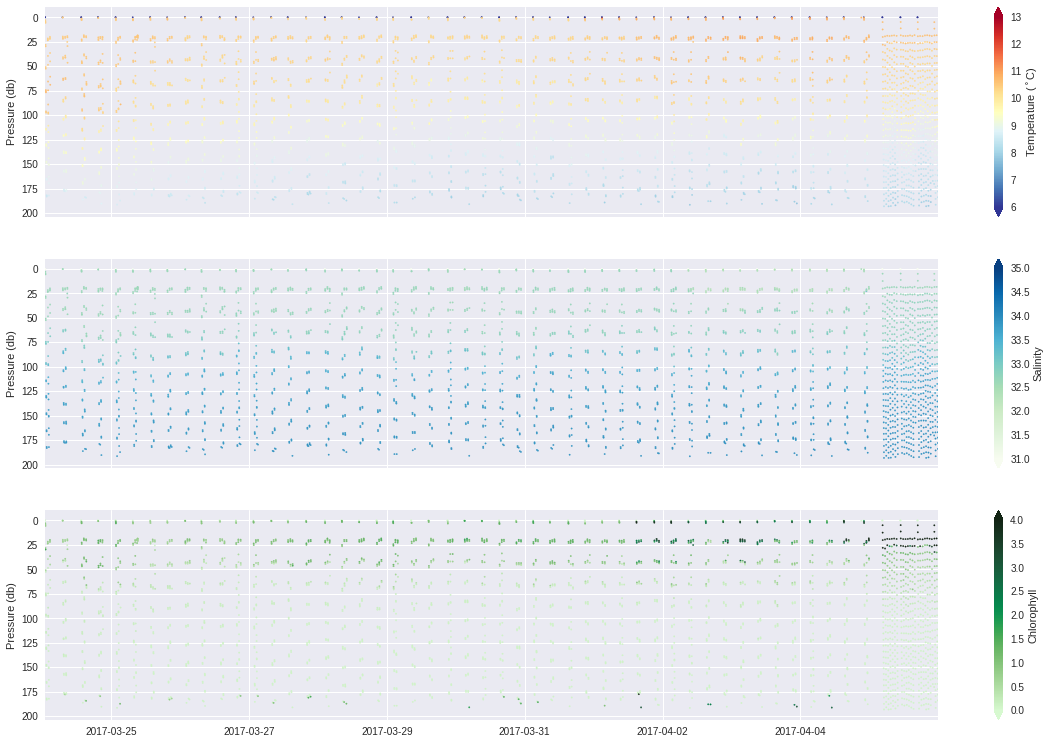

In [0]:
#GL383 Comparing temperature and salitiny for the subsetted Data for the intesting deep chlorphyll high
ds383time = ds383['time'].values[20034:23131]
ds383pressure = ds383['int_ctd_pressure'].values[20034:23131]
ds383chlorophyll = ds383['sci_flbbcd_chlor_units'].values[20034:23131]
ds383temp = ds383['sci_water_temp'].values[20034:23131]
ds383salinity = ds383['practical_salinity'].values[20034:23131]
ds383lat = ds383['lat'].values[20034:23131]
ds383lon = ds383['lon'].values[20034:23131]

fig, (ax1,ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,12))
sc1 = ax1.scatter(ds383time, ds383pressure, c=ds383temp, cmap='RdYlBu_r', s=2)
sc1.set_clim(6, 13)
sc2 = ax2.scatter(ds383time, ds383pressure, c=ds383salinity, cmap='GnBu', s=2)
sc2.set_clim(31, 35)
sc3 = ax3.scatter(ds383time, ds383pressure, c=ds383chlorophyll, cmap=cmocean.cm.algae, s=2)
sc3.set_clim(0, 4)

# Because the X and Y axes are shared, we only have to set limits once
ax2.invert_yaxis() # Invert y axis
ax2.set_xlim(ds383time[0],ds383time[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')
ax3.set_ylabel('Pressure (db)')
fig.subplots_adjust(top=0.95);

It is unclear why there is a high increase in cholorphyll at depth. During the time of the chlorophyll increase, the track of the glider apears to deviate as if it is in a stuck in a current feature.  However the temperature and salinity values do not change from the trend during this time suggesting that there is not upwelling occuring that could lead to this increase. We checked satellite current, wind, and chlorophyll data in the area of the gilder and there were no features apparent. 

The closest concurrent dataset of the water column available is at the Coastal Endurance Oregon Offshore site, which has both a shallow profiler and a surface mooring.  For context, below is a map of the locations we're interested in.

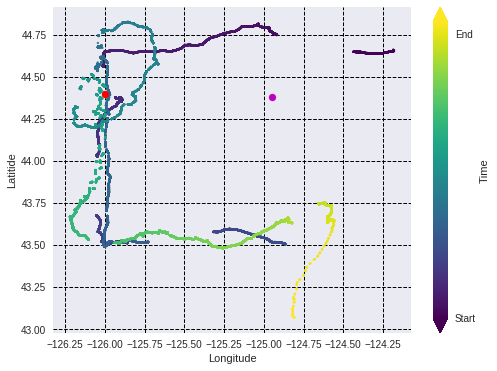

In [0]:
latInt=44.4
lonInt=-126
latMooring=44.38177	
lonMooring=-124.94973

fig, (ax1) = plt.subplots(1,1, figsize=(8,6))
sc1 = ax1.scatter(ds383['lon'].values, ds383['lat'].values, c=ds383['time'].values, cmap='viridis', s=4, label='Glider Track')
sc2 = ax1.scatter(lonInt, latInt, c='r', label='Point of Interest')
sc3 = ax1.scatter(lonMooring, latMooring, c='m', label='CE04OS')
ax1.set_ylabel('Latitide')
ax1.set_xlabel('Longitude')
ax1.grid(color='k', linestyle='--', linewidth=1)
fig1.suptitle('GL383')
cbar = fig1.colorbar(sc1,ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Time')
cbar.set_ticks([ds383['time'].values[100].astype('float'),ds383['time'].values[-100].astype('float')])
cbar.ax.set_yticklabels(['Start','End']);

#### 7a. Bringing in outside data sources

Since we just want a month worth of data, lets use JSON to make that request and get it into our workspace.

In [0]:
# Time Processing Routine we'll need
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

# Surface mooring data
#CE04OSSM-RID27-02-FLORTD000
# Instrument Information, gathered from the data portal website
subsite = 'CE04OSSM'
node = 'RID27' #381 might be useful
sensor = '02-FLORTD000'
method = 'telemetered'
stream = 'flort_sample'
beginDT = '2017-03-01T01:01:01.900Z'
endDT = '2017-05-01T01:01:01.900Z'

# We need the url for the M2M API
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# And we'll set our data params for the time window of interest defined above
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
     'beginDT':beginDT,
     'endDT':endDT,
     'limit':10000,   
}

r = requests.get(data_request_url, params=params,auth=(username, token))
data = r.json()

timeSurf = []
pressureSurf = []
chlorSurf = []
for i in range(len(data)):
  timeSurf.append(ntp_seconds_to_datetime(data[i]['internal_timestamp']))
  pressureSurf.append(data[i]['pressure_depth'])
  chlorSurf.append(data[i]['fluorometric_chlorophyll_a'])
  
# Shallow Profiler data
#CE04OSPS-SF01B-3A-FLORTD104
# Instrument Information, gathered from the data portal website
subsite = 'CE04OSPS'
node = 'SF01B' #381 might be useful
sensor = '3A-FLORTD104'
method = 'streamed'
stream = 'flort_d_data_record'

# We have to rebuild the url and params with the new info above
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
     'beginDT':beginDT,
     'endDT':endDT,
     'limit':10000,   
}

r = requests.get(data_request_url, params=params,auth=(username, token))
data = r.json()

timeProf = []
pressureProf = []
chlorProf = []
for i in range(len(data)):
  timeProf.append(ntp_seconds_to_datetime(data[i]['internal_timestamp']))
  pressureProf.append(data[i]['int_ctd_pressure'])
  chlorProf.append(data[i]['fluorometric_chlorophyll_a'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


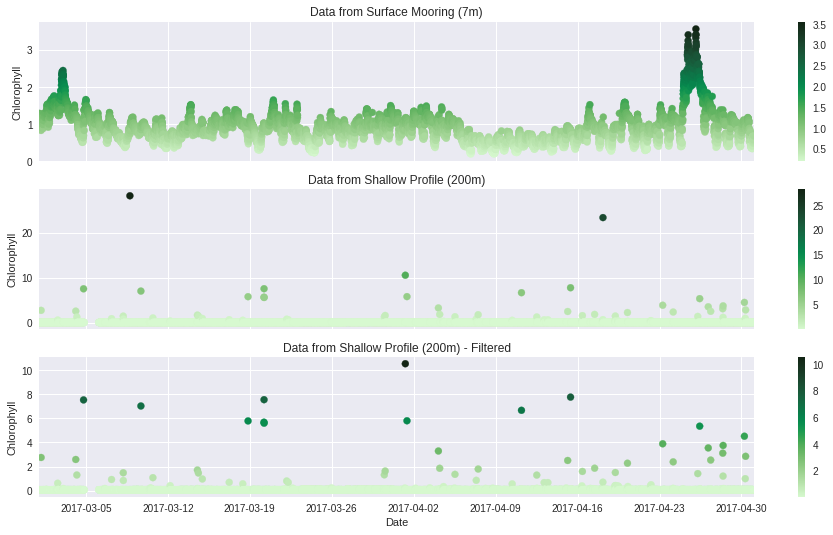

In [0]:
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=(16,8), sharex=True)

plt1 = ax1.scatter(timeSurf,chlorSurf,c=chlorSurf,cmap=cmocean.cm.algae)
ax1.set_ylabel('Chlorophyll')
ax1.set_title('Data from Surface Mooring (7m)');
ax1.set_xlim(timeSurf[0],timeSurf[-1]) # Set the time limits to match the dataset
fig.colorbar(plt1,ax=ax1)

plt2 = ax2.scatter(timeProf,chlorProf,c=chlorProf,cmap=cmocean.cm.algae)
ax2.set_ylabel('Chlorophyll')
ax2.set_title('Data from Shallow Profile (200m)');
ax2.set_xlim(timeSurf[0],timeSurf[-1]) # Set the time limits to match the dataset
fig.colorbar(plt2,ax=ax2)

plt3 = ax3.scatter(np.array(timeProf)[np.array(chlorProf) <20],np.array(chlorProf)[np.array(chlorProf) <20],c=np.array(chlorProf)[np.array(chlorProf) <20],cmap=cmocean.cm.algae)
ax3.set_xlabel('Date')
ax3.set_ylabel('Chlorophyll')
ax3.set_title('Data from Shallow Profile (200m) - Filtered');
ax3.set_xlim(timeSurf[0],timeSurf[-1]) # Set the time limits to match the dataset
fig.colorbar(plt3,ax=ax3)


ax4.scatter(ds383['time'].values[(ds383['int_ctd_pressure'].values >0)],ds383['sci_flbbcd_chlor_units'].values[(ds383['int_ctd_pressure'].values >0)],c=ds383['sci_flbbcd_chlor_units'].values[(ds383['int_ctd_pressure'].values >0)],cmap=cmocean.cm.algae)
ax4.scatter(ds383['time'].values[(ds383['sci_flbbcd_chlor_units'].values < 0)],ds383['sci_flbbcd_chlor_units'].values[(ds383['sci_flbbcd_chlor_units'].values <0)],color='m')
ax4.set_title('')
ax4.set_xlabel('Time')
ax4.set_ylabel('Chlorophyll')
ax4.set_xlim(ds383['time'].values[0],ds383['time'].values[-1]) # Set the time limits to match the dataset
fig.subplots_adjust(top=0.95);

It appears that the increase in chlorophyll seen from about 175 - 200 meters in  GL383 is consistant with the increase seen in the shallow profiler.  This profiler was in the vicinity of GL383 and was at a similar depth.  It had an increase over a similar time period as was seen for GL383's increase in chlorophyll. NOTE: The profiler was stuck between 204 and 206 meters and was not actually profiling which was beneficial for this test. 

For the shallow increase, this does not match the data at the surface mooring in the vicinty during the same time period, leading us to wonder if this is an error in the Glider data or just a very localized increase.

In doing this test, we isolated an issue that the Shallow Profile appeared to have.  It appears that there are two very high chlorophyll values (greater than 20) during this time period that are probably not real values based on the data from the glider.

##  **8. Investigating CTD Data**
It looks like throughout the glider fluorometer dateset, there are abnormal values being recorded at the surface.  We'll look through the entire dataset for both gliders for the values of temperature, salinity, and chlorophyll being recorded at a depth of 0.

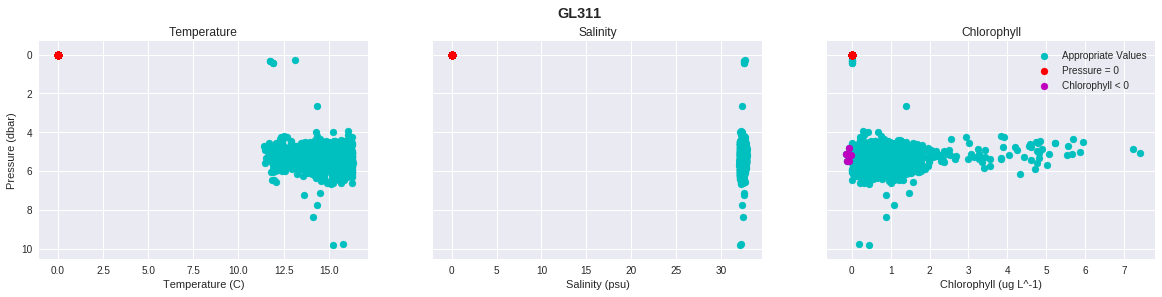

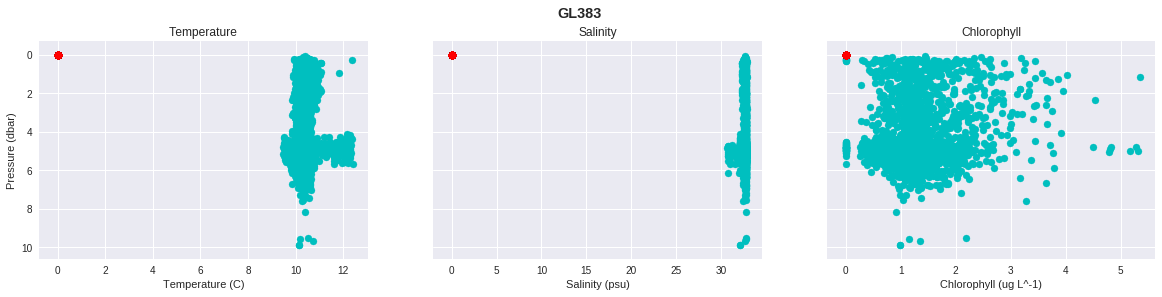

In [0]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, sharex=False, sharey=True, figsize=(20,4))
fig.suptitle('GL311',y=1,weight ='bold')
ax1.scatter(ds311['sci_water_temp'][ds311['int_ctd_pressure'] <10],ds311['int_ctd_pressure'][ds311['int_ctd_pressure'] <10],color='c')
ax1.scatter(ds311['sci_water_temp'][ds311['int_ctd_pressure'] ==0],ds311['int_ctd_pressure'][ds311['int_ctd_pressure'] ==0],color='r')
ax1.set_title('Temperature')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.invert_yaxis()

ax2.scatter(ds311['practical_salinity'][ds311['int_ctd_pressure'] <10],ds311['int_ctd_pressure'][ds311['int_ctd_pressure'] <10],color='c')
ax2.scatter(ds311['practical_salinity'][ds311['int_ctd_pressure'] ==0],ds311['int_ctd_pressure'][ds311['int_ctd_pressure'] ==0],color='r')
ax2.set_title('Salinity')
ax2.set_xlabel('Salinity (psu)')

ax3.scatter(ds311['sci_flbbcd_chlor_units'][ds311['int_ctd_pressure'] <10],ds311['int_ctd_pressure'][ds311['int_ctd_pressure'] <10],color='c',label='Appropriate Values')
ax3.scatter(ds311['sci_flbbcd_chlor_units'][ds311['int_ctd_pressure'] ==0],ds311['int_ctd_pressure'][ds311['int_ctd_pressure'] ==0],color='r',label = 'Pressure = 0')
ax3.scatter(ds311['sci_flbbcd_chlor_units'][(ds311['int_ctd_pressure'] <10) & (ds311['sci_flbbcd_chlor_units'] <0)],ds311['int_ctd_pressure'][(ds311['int_ctd_pressure'] <10) & (ds311['sci_flbbcd_chlor_units'] <0)], label='Chlorophyll < 0',color='m')
ax3.set_title('Chlorophyll')
ax3.set_xlabel('Chlorophyll (ug L^-1)')
ax3.legend()

fig2, (ax1,ax2, ax3) = plt.subplots(1,3, sharex=False, sharey=True, figsize=(20,4))
fig2.suptitle('GL383',y=1,weight ='bold')
ax1.scatter(ds383['sci_water_temp'][ds383['int_ctd_pressure'] <10],ds383['int_ctd_pressure'][ds383['int_ctd_pressure'] <10],color='c')
ax1.scatter(ds383['sci_water_temp'][ds383['int_ctd_pressure'] ==0],ds383['int_ctd_pressure'][ds383['int_ctd_pressure'] ==0],color='r')
ax1.set_title('Temperature')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.invert_yaxis()

ax2.scatter(ds383['practical_salinity'][ds383['int_ctd_pressure'] <10],ds383['int_ctd_pressure'][ds383['int_ctd_pressure'] <10],color='c')
ax2.scatter(ds383['practical_salinity'][ds383['int_ctd_pressure'] ==0],ds383['int_ctd_pressure'][ds383['int_ctd_pressure'] ==0],color='r')
ax2.set_title('Salinity')
ax2.set_xlabel('Salinity (psu)');

ax3.scatter(ds383['sci_flbbcd_chlor_units'][ds383['int_ctd_pressure'] <10],ds383['int_ctd_pressure'][ds383['int_ctd_pressure'] <10],color='c',label='Appropriate Values')
ax3.scatter(ds383['sci_flbbcd_chlor_units'][ds383['int_ctd_pressure'] ==0],ds383['int_ctd_pressure'][ds383['int_ctd_pressure'] ==0],color='r',label = 'Pressure = 0')
ax3.scatter(ds383['sci_flbbcd_chlor_units'][(ds383['int_ctd_pressure'] <10) & (ds383['sci_flbbcd_chlor_units'] <0)],ds383['int_ctd_pressure'][(ds383['int_ctd_pressure'] <10) & (ds383['sci_flbbcd_chlor_units'] <0)], label='Chlorophyll < 0',color='m')
ax3.set_title('Chlorophyll')
ax3.set_xlabel('Chlorophyll (ug L^-1)');

It appears that there is a false data point being stored by the fluorometer at a depth of zero when the glider surfaces.  To investigate further, we'll open up one of the CTD files which serves as the dependency for the chlorophyll calculations, just to confirm that the issue is in the original data.

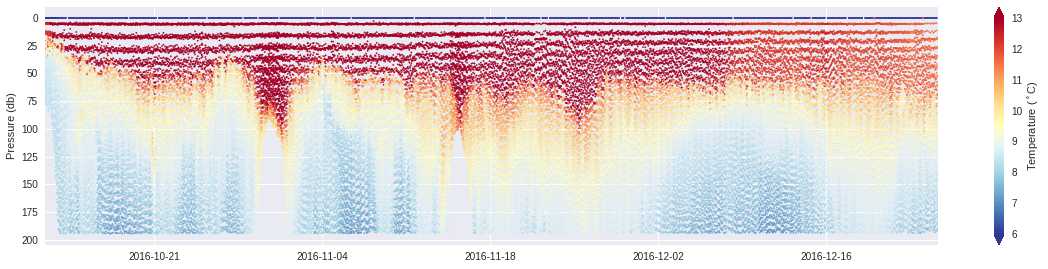

In [0]:
ds311CTD = xr.open_dataset(dataCTD[0])
ds311CTD = ds311CTD.swap_dims({'obs': 'time'}) 
ds311CTD.time.values,ds311CTD.sci_water_pressure_dbar.values

fig, (ax1) = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,4))
sc1 = ax1.scatter(ds311CTD.time.values, ds311CTD.sci_water_pressure_dbar.values, c=ds311CTD.sci_water_temp.values, cmap='RdYlBu_r', s=2)
sc1.set_clim(6, 13)
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(ds311CTD.time.values[0],ds311CTD.time.values[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (db)')
fig.subplots_adjust(top=0.95);

As you can see in this figure, CTD temperature values are 0 at a depth of 0 when the glider surfaces.  This is seen in both glider dataset, GL311 and GL383.  These values are much lower than the rest of the data.  We recommend if you are integrating over the dataset to make sure to integrate values with a depth greater than zero to remove this artifact.



## **9. Investigating Negative Chlorophyll Values and Checking QC Flags**
Let's take a look at the temporal and spatial distribution of those negative values that were found, to see if there's additional values outside of the upper water column shown above.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


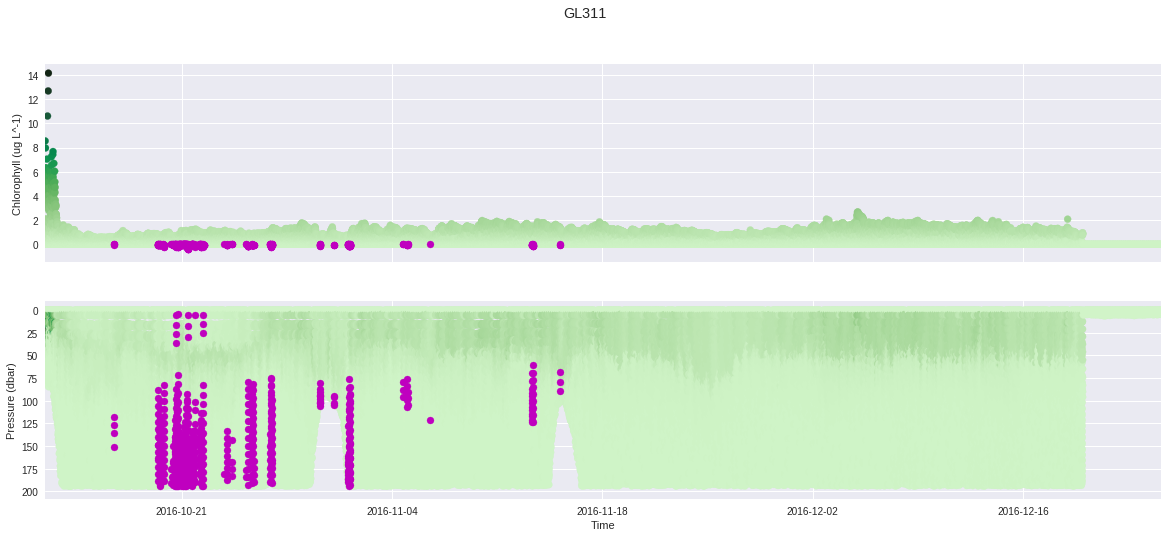

In [88]:
#Now lets look at this spike in cholophyll over time
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=False, figsize=(20,8))
fig.suptitle('GL311')

ax1.scatter(ds311['time'].values,ds311['sci_flbbcd_chlor_units'].values,c=ds311['sci_flbbcd_chlor_units'].values,cmap=cmocean.cm.algae)
ax1.scatter(ds311['time'].values[ds311['sci_flbbcd_chlor_units'].values < 0],ds311['sci_flbbcd_chlor_units'].values[ds311['sci_flbbcd_chlor_units'].values < 0],color='m')
ax1.set_title('')
ax1.set_ylabel('Chlorophyll (ug L^-1)')
ax1.set_xlim(ds311['time'].values[0],ds311['time'].values[-1]) # Set the time limits to match the dataset

ax2.scatter(ds311['time'].values,ds311['int_ctd_pressure'].values,c=ds311['sci_flbbcd_chlor_units'].values,cmap=cmocean.cm.algae)
ax2.scatter(ds311['time'].values[ds311['sci_flbbcd_chlor_units'].values < 0],ds311['int_ctd_pressure'].values[ds311['sci_flbbcd_chlor_units'].values < 0],color='m')
ax2.set_title('')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_xlim(ds311['time'].values[0],ds311['time'].values[-1]) # Set the time limits to match the dataset
ax2.invert_yaxis()


It looks like there is a high density of negative flourometer values throughout the water column, starting in October of 2016.  Lets check to make sure there's qc flags in there.

In [89]:
df = ds311[['sci_m_present_time', 'sci_flbbcd_chlor_units','sci_flbbcd_chlor_units_qc_results','sci_flbbcd_chlor_units_qc_executed','int_ctd_pressure']].to_dataframe()
df.head()

sci_m_present_time  \
time                                                          
2016-10-11 21:58:49.332760064 2016-10-11 21:58:49.332760064   
2016-10-11 22:02:25.364009984 2016-10-11 22:02:25.364009984   
2016-10-11 22:03:25.969480192 2016-10-11 22:03:25.969479936   
2016-10-11 22:04:26.327759872 2016-10-11 22:04:26.327759872   
2016-10-11 22:05:27.310329856 2016-10-11 22:05:27.310329856   

                               sci_flbbcd_chlor_units  \
time                                                    
2016-10-11 21:58:49.332760064                  0.0000   
2016-10-11 22:02:25.364009984                  5.2195   
2016-10-11 22:03:25.969480192                  6.3218   
2016-10-11 22:04:26.327759872                  8.5483   
2016-10-11 22:05:27.310329856                  5.6794   

                               sci_flbbcd_chlor_units_qc_results  \
time                                                               
2016-10-11 21:58:49.332760064                               29.0   
2016-10-11 22:02:25.364009984                               29.0   
2016-10-11 22:03:25.969480192                               29.0   
2016-10-11 22:04:26.327759872                               29.0   
2016-10-11 22:05:27.310329856                               29.0   

                               sci_flbbcd_chlor_units_qc_executed  \
time                                                                
2016-10-11 21:58:49.332760064                                29.0   
2016-10-11 22:02:25.364009984                                29.0   
2016-10-11 22:03:25.969480192                                29.0   
2016-10-11 22:04:26.327759872                                29.0   
2016-10-11 22:05:27.310329856                                29.0   

                               int_ctd_pressure  obs         lon        lat  
time                                                                         
2016-10-11 21:58:49.332760064              0.00    0 -124.317307  44.635689  
2016-10-11 22:02:25.364009984              4.53    1 -124.318149  44.635532  
2016-10-11 22:03:25.969480192             12.44    2 -124.318289  44.635675  
2016-10-11 22:04:26.327759872             20.98    3 -124.318445  44.635609  
2016-10-11 22:05:27.310329856             28.51    4 -124.318603  44.635543

In [0]:
def parse_qc(df):
    vars = [x.split('_qc_results')[0] for x in df.columns if 'qc_results' in x]
    results = [x+'_qc_results' for x in vars]
    executed = [x+'_qc_executed' for x in vars]
    key_list = vars + results + executed

    for var in vars:
        qc_result = var + '_qc_results'
        qc_executed = var + '_qc_executed'
        names = {
            0: var + '_global_range_test',
            1: var + '_dataqc_localrangetest',
            2: var + '_dataqc_spiketest',
            3: var + '_dataqc_polytrendtest',
            4: var + '_dataqc_stuckvaluetest',
            5: var + '_dataqc_gradienttest',
            7: var + '_dataqc_propagateflags',
        }
        # Just in case a different set of tests were run on some datapoint. *This should never happen*
        executed = np.bitwise_or.reduce(df[qc_executed].values)
        executed_bits = np.unpackbits(executed.astype('uint8'))
        for index, value in enumerate(executed_bits[::-1]):
            if value:
                name = names.get(index)
                mask = 2 ** index
                values = (df[qc_result].values & mask) > 0
                df[name] = values
        df.drop([qc_executed, qc_result], axis=1, inplace=True)
    return df

In [0]:
df_qc =  parse_qc(df)
df_qc.head()

In [0]:
df_qc[df_qc['sci_flbbcd_chlor_units_global_range_test'] == False].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


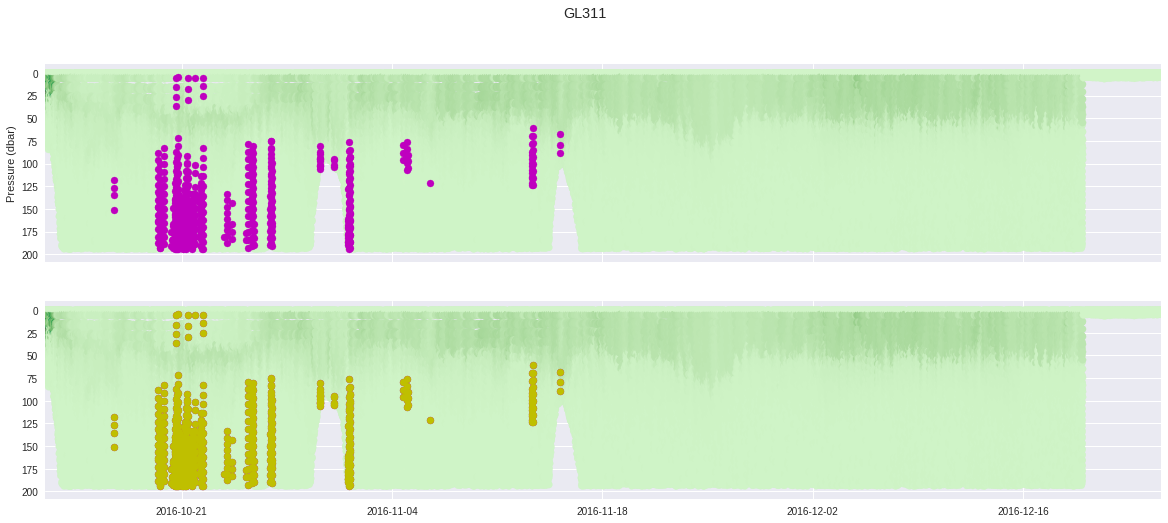

In [0]:
# Get out instrument values
time = list(df['sci_m_present_time'].values)
chlor = list(df['sci_flbbcd_chlor_units'].values)
pres = list(df['int_ctd_pressure'].values)
# Get our timestamps where the chlorophyll data fails the global range test
qcTime = df_qc['sci_m_present_time'][df_qc['sci_flbbcd_chlor_units_global_range_test'] == False].values
qcPres = df_qc['int_ctd_pressure'][df_qc['sci_flbbcd_chlor_units_global_range_test'] == False].values

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=False, figsize=(20,8))
fig.suptitle('GL311')
# plot where the negative values are in the water column
ax1.scatter(ds311['time'].values,ds311['int_ctd_pressure'].values,c=ds311['sci_flbbcd_chlor_units'].values,cmap=cmocean.cm.algae)
ax1.scatter(ds311['time'].values[ds311['sci_flbbcd_chlor_units'].values < 0],ds311['int_ctd_pressure'].values[ds311['sci_flbbcd_chlor_units'].values < 0],color='m',label='Chlor <0')
ax1.set_title('')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlim(ds311['time'].values[0],ds311['time'].values[-1]) # Set the time limits to match the dataset
ax1.invert_yaxis()
# layer on where the flags are and lets make sure they all line up
ax2.scatter(time,pres,c=chlor,cmap=cmocean.cm.algae)
ax2.scatter(ds311['time'].values[ds311['sci_flbbcd_chlor_units'].values < 0],ds311['int_ctd_pressure'].values[ds311['sci_flbbcd_chlor_units'].values < 0],color='m')
ax2.scatter(qcTime, qcPres,c='y', label='Global Value Flags')
ax2.set_xlim(np.min(time),np.max(time)) # Set the time limits to match the dataset
ax2.invert_yaxis()

print(len(ds311['time'].values[ds311['sci_flbbcd_chlor_units'].values < 0]))

Looks like the robots are doing their job, all of the negative values fail the global range test and can be masked out.

Let's just take a look to see if there's a similar problematic area in the GL383 data.  Negative values (as above) will be in magenta.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(736360.859005227, 736459.7430330206)

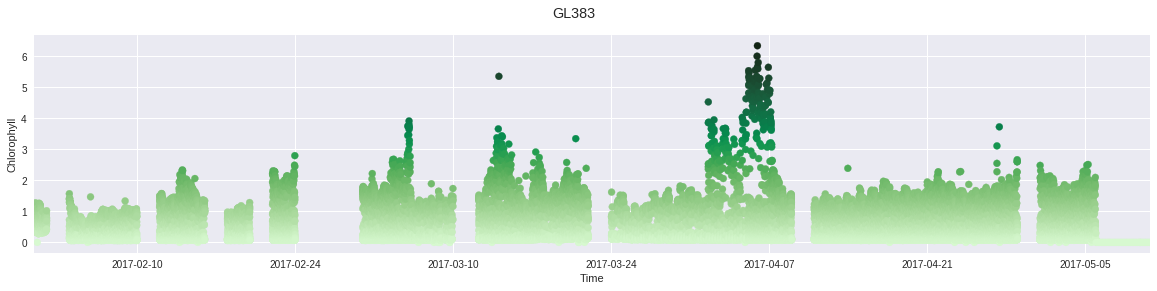

In [0]:
#Lets check GL383 for negative values
fig,ax1 = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,4))
fig.suptitle('GL383')
ax1.scatter(ds383['time'].values[(ds383['int_ctd_pressure'].values >0)],ds383['sci_flbbcd_chlor_units'].values[(ds383['int_ctd_pressure'].values >0)],c=ds383['sci_flbbcd_chlor_units'].values[(ds383['int_ctd_pressure'].values >0)],cmap=cmocean.cm.algae)
ax1.scatter(ds383['time'].values[(ds383['sci_flbbcd_chlor_units'].values < 0)],ds383['sci_flbbcd_chlor_units'].values[(ds383['sci_flbbcd_chlor_units'].values <0)],color='m')
ax1.set_title('')
ax1.set_xlabel('Time')
ax1.set_ylabel('Chlorophyll')
ax1.set_xlim(ds383['time'].values[0],ds383['time'].values[-1]) # Set the time limits to match the dataset


It looks like there are no negative values for GL383.  So this one is all good.  Yay!

##**10. Notable Results and Actions Needed**

Issues encountered during the making of this report:

*   We had an API data access issue with the netCDF runtime timeout error during the THREDDS requests for one of the datasets, so we used a Google Colab local file upload.  We directly uploaded the data from a local drive to get around this issue.
*   We found different sampling rates between the two gliders leading to differing amounts of date over the same time period. (see the code below)  This is not an issue per se but somthing to keep in mind if comparing two different glider datasets.  For example:
> *  One day of GL311: 1580 time points
> * One day of GL383: 412 time points
*   The GL383 sampling rate changed half way through the deployment and then changed again.  For scientists, it is important to remember that the pilots can change the sample rate of the gliders throughout the deployment so this can lead to spatially patchy data.
* The data for both GL311 and GL383 included values at a water depth of zero when the glider surfaced. These values are zero and can affect your data when comparing over the water column. For scientists integrating data over the water column, make sure to intergrate over a depth greater than zero.
* For GL311, we found that there were negative chlorophyll values in the dataset.  We checked if these values were flagged as bad data and they were all correctly flagged.  We recommend that an annotation be added to the dataset for the time of these negative values because there are many of them clustered together.
* For GL383, we found an increase in chlorophyll values from about 175 - 200 meters partway through the deployment.  However these values matched an increase in a nearby fluorometer sensor.
* For GL383, a shallow water chlorophyll increase did not match a fluorometer on a moored instrument, CE04OSSM-RID27-02-FLORTD000 nearby.  This chlorophyll increase should be investigated more in the future.
* For CE04OSPS-SF01B-3A-FLORTD104 there were multiple very high chlorophyll values that seemed to be incorrect.  This should be investigated more in the future.


Text(0,0.5,'Sampling Interval (s)')

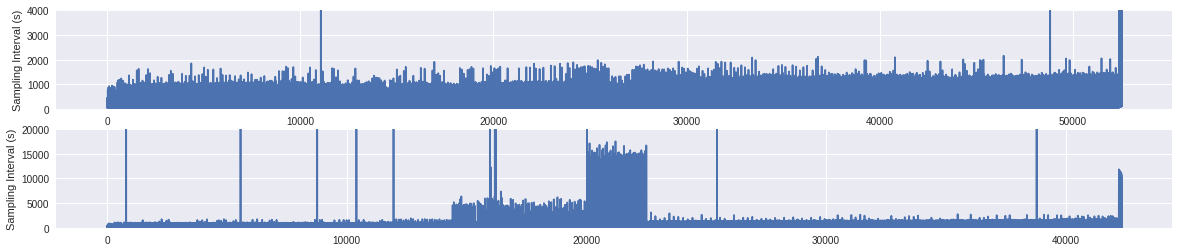

In [0]:
# Lets figure out the time steps between every data point
freq311 = []
for d in range(len(ds311['time'].values)-1):
  freq311.append((ds311['time'].values[d+1] - ds311['time'].values[d])/np.timedelta64(1, 's'))
  
freq383 = []
for d in range(len(ds383['time'].values)-1):
  freq383.append((ds383['time'].values[d+1] - ds383['time'].values[d])/np.timedelta64(1, 's'))

# And plot it to look for big anomolies
fig, (ax1,ax2) = plt.subplots(2,1, figsize =(20,4))
ax1.plot(freq311)
ax1.set_ylim(0,4000)
ax1.set_ylabel('Sampling Interval (s)')
ax2.plot(freq383)
ax2.set_ylim(0,20000)
ax2.set_ylabel('Sampling Interval (s)')

In [0]:
# Just some housekeeping, we can use this block to keep tabs on how much space google is giving us and how much we have left
!pip install psutil
!pip install humanize
import psutil
import humanize
humanize.naturalsize(psutil.virtual_memory().available )